The data is from the hiPSC single cell image dataset from the Allen Institute for Cell Science: https://open.quiltdata.com/b/allencell/packages/aics/hipsc_single_cell_image_dataset. Original publication of the data: 

Viana, M.P., Chen, J., Knijnenburg, T.A. et al. Integrated intracellular organization and its variations in human iPS cells. Nature 613, 345–354 (2023). https://doi.org/10.1038/s41586-022-05563-7

In [1]:
# you need quilt3 package to download the data:
! pip install quilt3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 32.7 MB/s eta 0:00:00
  Using cached requests_futures-1.0.0-py2.py3-none-any.whl (7.4 kB)
  Using cached aws_requests_auth-0.4.3-py2.py3-none-any.whl (6.8 kB)
  Using cached jsonlines-1.2.0-py2.py3-none-any.whl (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 92.7 MB/s eta 0:00:0000:0100:01
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)


In [1]:
import pandas as pd
import quilt3
from pathlib import Path
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from random import random

In [2]:
# turn off pandas parser warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# tunr off ome_types parser warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# set parameters

# which cell line to download: in the paper, we tested on four nuclear structures:
# - fibrillarin (cline = "FBL")
# - nucleophosmin (cline = "NPM1")
# - lamin b1 (cline = "LMNB1")
# - histon H2B (cline = "HIST1H2BJ")
cline = "FBL"
num_samples_per_cell_line = 500 # with roughly 80/20 training/validation split 

# set up path
parent_path = Path("./data/labelfree2D") / f"{cline}"
parent_path.mkdir(exist_ok=True,parents=True)

raw_path = parent_path / Path("download")
raw_path.mkdir(exist_ok=True)
train_path = parent_path / Path("train")
train_path.mkdir(exist_ok=True)
holdout_path = parent_path / Path("holdout")
holdout_path.mkdir(exist_ok=True)

In [26]:
# connect to quilt and load meta table
pkg = quilt3.Package.browse(
    "aics/hipsc_single_cell_image_dataset", registry="s3://allencell"
)
meta_df_obj = pkg["metadata.csv"]
meta_df_obj.fetch(parent_path / "meta.csv")
meta_df = pd.read_csv(parent_path / "meta.csv")

# fetch the data of the specific cell line
meta_df_line = meta_df.query("structure_name==@cline")

# collapse the data table based on FOVId
meta_df_line.drop_duplicates(subset="FOVId", inplace=True)

# reset index
meta_df_line.reset_index(drop=True, inplace=True)

Loading manifest: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484465/484465 [00:12<00:00, 37.7k/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.69G/1.69G [00:36<00:00, 46.0MB/s]
/tmp/ipykernel_1907875/3370391117.py:7: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(parent_path / "meta.csv")
/tmp/ipykernel_1907875/3370391117.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_line.drop_duplicates(subset="FOVId", inplace=True)


In [22]:
# download the images and re-slice into input (BF) and ground truth (fluorescent) images
for row in meta_df_line.itertuples():
    if row.Index >= num_samples_per_cell_line:
        break
    
    # fetch the raw image (multi-channel)
    subdir_name = row.fov_path.split("/")[0]
    file_name = row.fov_path.split("/")[1]

    local_fn = raw_path / f"{row.FOVId}_original.tiff"
    pkg[subdir_name][file_name].fetch(local_fn)

    # extract the bf and structures channel
    reader = AICSImage(local_fn)
    bf_img = reader.get_image_data(
        "ZYX", C=row.ChannelNumberBrightfield, S=0, T=0
    )
    str_img = reader.get_image_data(
        "ZYX", C=row.ChannelNumberStruct, S=0, T=0
    )

    if random() < 0.2:
        data_path = holdout_path
    else:
        data_path = train_path

    im_fn = data_path / f"{row.FOVId}_IM.tiff"
    gt_fn = data_path / f"{row.FOVId}_GT.tiff"
    OmeTiffWriter.save(bf_img, im_fn, dim_order="ZYX")
    OmeTiffWriter.save(str_img, gt_fn, dim_order="ZYX")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:15<00:00, 25.1MB/s]
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d =

In [27]:
# download the images and re-slice into input (BF) and ground truth (fluorescent) images
for row in meta_df_line.itertuples():
    if row.Index >= num_samples_per_cell_line:
        break
    
    # fetch the raw image (multi-channel)
    subdir_name = row.fov_path.split("/")[0]
    file_name = row.fov_path.split("/")[1]

    local_fn = raw_path / f"{row.FOVId}_original.tiff"
    pkg[subdir_name][file_name].fetch(local_fn)

    # extract the bf and structures channel
    reader = AICSImage(local_fn)
    bf_img = reader.get_image_data(
        "ZYX", C=row.ChannelNumberBrightfield, S=0, T=0
    )
    str_img = reader.get_image_data(
        "ZYX", C=row.ChannelNumberStruct, S=0, T=0
    )

    # extract the middle slice from each 3D image
    middle_slice_index = bf_img.shape[0] // 2
    bf_img_2d = bf_img[middle_slice_index, :, :]
    str_img_2d = str_img[middle_slice_index, :, :]

    if random() < 0.2:
        data_path = holdout_path
    else:
        data_path = train_path

    im_fn = data_path / f"{row.FOVId}_IM.tiff"
    gt_fn = data_path / f"{row.FOVId}_GT.tiff"
    OmeTiffWriter.save(bf_img_2d, im_fn, dim_order="YX")
    OmeTiffWriter.save(str_img_2d, gt_fn, dim_order="YX")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:16<00:00, 22.9MB/s]
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d =

In [28]:
# you may remove the download folder now.
from shutil import rmtree
import os
rmtree(raw_path)
os.remove(parent_path / "meta.csv")


# Classic Compression

In [5]:
### Defining compression method (by r/w tmp file)
import tifffile
import os

def wasteful_compression(img, compression):
    try:
        os.remove('/mnt/eternus/users/Jan/code/temp.tiff')
    except OSError:
        pass
    tifffile.imwrite(
         '/mnt/eternus/users/Jan/code/temp.tiff',
         img,
         bigtiff=True,
         photometric='minisblack',
         planarconfig='separate',
         tile=(16, 16),
         compression=compression,
         compressionargs={'level': 8},
         predictor=True,
         metadata={'axes': 'YX'}
        )
    sample_path = Path("./temp.tiff")
    reader = AICSImage(sample_path)
    img = reader.get_image_data('YX') 
    return img

compression_techniques = ['JPEGXR','JPEG_2000_LOSSY','LERC']

In [6]:
### Compression with classic techniques and appending 'original' 'method'
import shutil

def compress_dir(compression, path, copy_gt=True):
    output_path = path / Path(compression)
    output_path.mkdir(parents=True, exist_ok=True)
    for image_path in path.glob('*.tiff'):
        output_image_path = output_path / Path(image_path.name)
        if not output_image_path.is_file():
            if image_path.name.endswith('GT.tiff') and copy_gt:
                shutil.copyfile(image_path, output_image_path)
            elif image_path.name.endswith('IM.tiff'):
                reader = AICSImage(image_path)
                img = reader.get_image_data('YX')
                OmeTiffWriter.save(wasteful_compression(img,compression), output_image_path, dim_order='YX')  
    
def extract_origin_dir(path):
    output_path = path / Path('original')
    output_path.mkdir(parents=True, exist_ok=True)
    for image_path in path.glob('*IM.tiff'):
        output_image_path = output_path / Path(image_path.name)
        if not output_image_path.is_file():
            shutil.copyfile(image_path, output_image_path)

for compression in compression_techniques:
    compress_dir(compression,train_path)
    compress_dir(compression,holdout_path,False)
    
extract_origin_dir(holdout_path)
compression_techniques.append('original')

# Deep Leanring Compression

In [14]:
!nvidia-smi
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
!export CUDA_VISIBLE_DEVICES=3 

Wed Feb 22 09:36:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:0E:00.0 Off |                    0 |
| N/A   28C    P0    53W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:13:00.0 Off |                    0 |
| N/A   

In [1]:
from compressai.zoo.image import cfgs
from compressai.zoo import image_models
import os



configurations=[]
for model in image_models.keys():
    for metric in ['mse','ms-ssim']:
        configurations.append((model,max(cfgs[model]),metric))

for config in configurations:
    output = f'/mnt/eternus/users/Jan/test_checkpoint_{config[0]}_{config[1]}_{config[2]}'
    if not os.path.exists(output+'.pth.tar'):
        print(output)
        !python3 /mnt/eternus/users/Jan/data/CompressAI/examples/train.py -d /mnt/eternus/users/Jan/code/data/labelfree3D/FBL/split_dir --epochs 300 -lr 1e-4 --test-batch-size 64 --batch-size 32 --model {config[0]} --metric {config[2]} --quality {config[1]} -o {output} --cuda --save 


#TODO train models and save checkpoints  

#TODO Branch with optional pre-trained RGB method also possible but maybe a bit too low level 

/mnt/eternus/users/Jan/test_checkpoint_mbt2018_8_ms-ssim
Learning rate: 0.0001
Train epoch 0: [0/836 (0%)]	Loss: 0.481 |	ms_ssim loss: 0.000 |	Bpp loss: 0.47 |	Aux loss: 7913.24
Train epoch 0: [320/836 (37%)]	Loss: 0.454 |	ms_ssim loss: 0.000 |	Bpp loss: 0.44 |	Aux loss: 7909.03
Train epoch 0: [640/836 (74%)]	Loss: 0.451 |	ms_ssim loss: 0.000 |	Bpp loss: 0.44 |	Aux loss: 7904.85
Test epoch 0: Average losses:	Loss: 0.259 |	ms_ssim loss: 0.000 |	Bpp loss: 0.25 |	Aux loss: 7902.39

Learning rate: 0.0001
Train epoch 1: [0/836 (0%)]	Loss: 0.449 |	ms_ssim loss: 0.000 |	Bpp loss: 0.44 |	Aux loss: 7902.07
Train epoch 1: [320/836 (37%)]	Loss: 0.449 |	ms_ssim loss: 0.000 |	Bpp loss: 0.44 |	Aux loss: 7898.58
Train epoch 1: [640/836 (74%)]	Loss: 0.447 |	ms_ssim loss: 0.000 |	Bpp loss: 0.44 |	Aux loss: 7895.19
Test epoch 1: Average losses:	Loss: 0.257 |	ms_ssim loss: 0.000 |	Bpp loss: 0.25 |	Aux loss: 7893.02

Learning rate: 0.0001
Train epoch 2: [0/836 (0%)]	Loss: 0.447 |	ms_ssim loss: 0.000 |	Bpp

In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", message="The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.*")

checkpoints_path= Path('/mnt/eternus/users/Jan/')
test_path= Path('/mnt/eternus/users/Jan/code/data/labelfree3D/FBL/split_dir/test')

for checkpoint in checkpoints_path.glob('*_best_loss.pth.tar'):
    print(checkpoint)
    for image in test_path.glob('*.tiff'):
        !python3 codec.py encode {image} --checkpoint {checkpoint._str} --output {image._str[:-5]+'_encoded'} --cuda
        !python3 codec.py decode {image._str[:-5]+'_encoded'} --checkpoint {checkpoint._str} --output {image._str[:-5]+'_decoded.tiff'} --cuda
        

/mnt/eternus/users/Jan/test_checkpoint_bmshj2018-factorized_8_ms-ssim_best_loss.pth.tar
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
0.064 bpp | Encoded in 3.81s (model loading: 1.86s)
Model: bmshj2018-factorized, metric: ms-ssim, quality: 8
/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old be

In [8]:
from compressai.zoo import models
import itertools 

model_list = models.keys()
metric = ['mse', 'ms-ssim']
#quality = [str(i) for i in range(1, 9)] 
quality = ['8']
settings_list = list(itertools.product(model_list, quality, metric))

for setting in [('bmshj2018-factorized', '8', 'mse')]:#settings_list:
    quality = setting[1]
    if setting[0] in ['cheng2020-anchor', 'cheng2020-attn', 'ssf2020']: #ssf2020 not yet available as pretrained model
        quality = '6'
    
    for image in holdout_path.glob('*IM*.tiff'): 
        model_name= setting[0]+'_'+setting[2]+'_'+quality
        path_encoded= image.parent/model_name/str(image.stem+'_encoded')
        path_encoded.parent.mkdir(exist_ok=True)
        path_decoded= image.parent/model_name/str(image.stem+'_decoded.tiff')
        path_decoded.parent.mkdir(exist_ok=True)
        if not path_decoded.is_file() or True:
            #print(path_decoded)
            #TODO: convert to new checkpoint-oriented approach -> iterate over models and execute / or train and iterate over checkpoints
            !python3 codec_modified.py encode {image} -o {path_encoded} --model {setting[0]} -q {quality} -m {setting[2]} --cuda
            !python3 codec_modified.py decode {path_encoded} -o {path_decoded} --cuda

Traceback (most recent call last):
  File "/mnt/eternus/users/Jan/code/codec_modified.py", line 651, in <module>
    main(sys.argv[1:])
  File "/mnt/eternus/users/Jan/code/codec_modified.py", line 645, in main
    encode(argv)
  File "/mnt/eternus/users/Jan/code/codec_modified.py", line 603, in encode
    _encode(
  File "/mnt/eternus/users/Jan/code/codec_modified.py", line 406, in _encode
    net = model_info(quality=quality, metric=metric, pretrained=True).to(device).eval()
  File "/mnt/eternus/users/Jan/data/compressai/compressai/zoo/image.py", line 296, in bmshj2018_factorized
    return _load_model(
  File "/mnt/eternus/users/Jan/data/compressai/compressai/zoo/image.py", line 269, in _load_model
    model = model_architectures[architecture].from_state_dict(state_dict)
  File "/mnt/eternus/users/Jan/data/compressai/compressai/models/google.py", line 181, in from_state_dict
    net.load_state_dict(state_dict)
  File "/mnt/eternus/users/Jan/data/compressai/compressai/models/google.py

^C
Traceback (most recent call last):
  File "/mnt/eternus/users/Jan/code/codec_modified.py", line 48, in <module>
    import compressai
  File "/mnt/eternus/users/Jan/data/compressai/compressai/__init__.py", line 30, in <module>
    from compressai import (
  File "/mnt/eternus/users/Jan/data/compressai/compressai/datasets/__init__.py", line 30, in <module>
    from .image import ImageFolder
  File "/mnt/eternus/users/Jan/data/compressai/compressai/datasets/image.py", line 33, in <module>
    from aicsimageio import AICSImage
  File "/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/aicsimageio/__init__.py", line 6, in <module>
    from .aics_image import AICSImage  # noqa: F401
  File "/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/aicsimageio/aics_image.py", line 12, in <module>
    from ome_types import OME
  File "/mnt/eternus/anaconda3_shared/envs/js_compression/lib/python3.9/site-packages/ome_types/__init__.py", line 11,

In [6]:
from compressai.zoo import models
import itertools 

model_list = models.keys()
metric = ['mse', 'ms-ssim']
#quality = [str(i) for i in range(1, 9)] 
quality = ['8']
settings_list = list(itertools.product(model_list, quality, metric))
settings_list

[('bmshj2018-factorized', '8', 'mse'),
 ('bmshj2018-factorized', '8', 'ms-ssim'),
 ('bmshj2018-hyperprior', '8', 'mse'),
 ('bmshj2018-hyperprior', '8', 'ms-ssim'),
 ('mbt2018-mean', '8', 'mse'),
 ('mbt2018-mean', '8', 'ms-ssim'),
 ('mbt2018', '8', 'mse'),
 ('mbt2018', '8', 'ms-ssim'),
 ('cheng2020-anchor', '8', 'mse'),
 ('cheng2020-anchor', '8', 'ms-ssim'),
 ('cheng2020-attn', '8', 'mse'),
 ('cheng2020-attn', '8', 'ms-ssim'),
 ('ssf2020', '8', 'mse'),
 ('ssf2020', '8', 'ms-ssim')]

In [ ]:
!run_im2im --config my_im2im_config_train_generator.yaml 
!run_im2im --config my_im2im_config_train.yaml 

In [41]:
prediction= 'prediction' 

for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:
    Path(dir/prediction).mkdir(exist_ok=True)
    !echo {dir.name}
    !run_im2im --config my_im2im_config_inference.yaml --data.inference_input.dir {dir} --data.inference_output.path {dir/prediction}

JPEGXR
2023-02-15 12:02:01,586 - Created a temporary directory at /tmp/tmpx6kys_au
2023-02-15 12:02:01,586 - Writing /tmp/tmpx6kys_au/_remote_module_non_scriptable.py
loading configuration from my_im2im_config_inference.yaml ...
configuration loading is completed
82 files are found at data/labelfree3D/FBL/holdout/JPEGXR
Reading the image 0/82
data/labelfree3D/FBL/holdout/JPEGXR/7644_IM.tiff
Predicting the image
Reading the image 1/82
data/labelfree3D/FBL/holdout/JPEGXR/7650_IM.tiff
Predicting the image
Reading the image 2/82
data/labelfree3D/FBL/holdout/JPEGXR/7668_IM.tiff
Predicting the image
Reading the image 3/82
data/labelfree3D/FBL/holdout/JPEGXR/7673_IM.tiff
Predicting the image
Reading the image 4/82
data/labelfree3D/FBL/holdout/JPEGXR/7679_IM.tiff
Predicting the image
Reading the image 5/82
data/labelfree3D/FBL/holdout/JPEGXR/7687_IM.tiff
Predicting the image
Reading the image 6/82
data/labelfree3D/FBL/holdout/JPEGXR/7693_IM.tiff
Predicting the image
Reading the image 7/82
data

# Evaluation 

In [42]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from pathlib import Path
import os
import sys
import numpy as np
from skimage.metrics import structural_similarity as ssim
import monai
import torch

def normalizeItensity(image):
    # Convert the image data to a floating-point data type
    img = image.astype(np.float32)
    # Convert the image to a toch Tensor
    img = torch.from_numpy(img)
    # Normalize the intensity of the image using the MONAI NormalizeIntensity transform
    normalize_intensity = monai.transforms.NormalizeIntensity()
    img_normalized = normalize_intensity(img)
    # Convert the normalized image back to a numpy array
    return img_normalized.numpy()

def compression_ratio_space_savings(image_path,values=924*624 ,bits=16):
    ratio= (values*bits) / (os.stat(image_path).st_size*8)
    savings= (1-(( os.stat(image_path).st_size*8) / (values*bits) ))
    return ratio, savings

def compare_images(path1, path2, gt=False):
    # Load the two images
    image1 = AICSImage(path1).get_image_data('YX') 
    image2 = AICSImage(path2).get_image_data('YX') 
    if gt:
        # image1 = image1.astype(np.float32)
        # # Scale the values in image1 to the range [0, 65535]
        # scaled_image = (image1 / np.max(image1) * 65535).round().astype(np.uint16)
        # image1 = scaled_image
        image2 = normalizeItensity(image2)
        #print(type(image1[0][0]), type(image2[0][0]))
    # Calculate metrics
    mse = np.mean((image1 - image2) ** 2)
    ssim_value = ssim(image1, image2, data_range=image1.max() - image1.min())
    corr = np.corrcoef(image1.ravel(), image2.ravel())[0, 1]
    psnr = 10 * np.log10(255**2 / (mse + 0.000001))
    return mse, ssim_value, corr, psnr

In [43]:
table_data = []
for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:
    space_savings = []
    compression_ratios = []
    pattern = '*_encoded'
    if dir.name in compression_techniques:
        pattern= '*.tiff'
    for image in dir.glob(pattern):
        r, s = compression_ratio_space_savings(image)
        space_savings.append(s)
        compression_ratios.append(r)
    table_data.append({
        'compressiontechnique': dir.name.replace('_','-'),
        'compressionratiomean': np.mean(compression_ratios),
        'compressionratioaverage': np.average(compression_ratios),
        'compressionratiomax': np.max(compression_ratios),
        'compressionratiomin': np.min(compression_ratios),
        'spacesavingmean': np.mean(space_savings),
        'spacesavingaverage': np.average(space_savings),
        'spacesavingmax': np.max(space_savings),
        'spacesavingmin': np.min(space_savings)
    })

df = pd.DataFrame(table_data)
df = df.round(4)
df.to_csv('compression.csv', index=False, sep=",", decimal=".")

In [44]:
import pandas as pd


table_data = []
for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]: 
    mses = []
    ssim_values = []
    corrs = []
    psnrs = []
    for image in dir.glob('*.tiff'):
        mse, ssim_value, corr, psnr = compare_images(image,dir.parent/ image.name.replace('_decoded','') )
        mses.append(mse)
        ssim_values.append(ssim_value)
        corrs.append(corr)
        psnrs.append(psnr)
    table_data.append({
        'dirname': dir.name.replace('_','-'),
        'msemean': np.mean(mses),
        'mseaverage': np.average(mses),
        'msehighest': np.max(mses),
        'mselowest': np.min(mses),
        'ssimmean': np.mean(ssim_values),
        'ssimaverage': np.average(ssim_values),
        'ssimhighest': np.max(ssim_values),
        'ssimlowest': np.min(ssim_values),
        'correlationmean': np.mean(corrs),
        'correlationaverage': np.average(corrs),
        'correlationhighest': np.max(corrs),
        'correlationlowest': np.min(corrs),
        'psnrmean': np.mean(psnrs),
        'psnraverage': np.average(psnrs),
        'psnrhighest': np.max(psnrs),
        'psnrlowest': np.min(psnrs)
    })
df = pd.DataFrame(table_data)
df = df.round(4)
df.to_csv('metrics_input.csv', index=False, sep=",", decimal=".")

In [45]:
table_data = []
for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:  
    print(dir.name)
    mses = []
    ssim_values = []
    corrs = []
    psnrs = []
    for image in Path(dir/'prediction').glob('*.tiff'):
        mse, ssim_value, corr, psnr = compare_images(image,dir.parent/ image.name.replace('_decoded','').replace('_pred','').replace('IM','GT') ,gt=True)
        mses.append(mse)
        ssim_values.append(ssim_value)
        corrs.append(corr)
        psnrs.append(psnr)
    table_data.append({
        'dirname': dir.name.replace('_','-'),
        'msemean': np.mean(mses),
        'mseaverage': np.average(mses),
        'msehighest': np.max(mses),
        'mselowest': np.min(mses),
        'ssimmean': np.mean(ssim_values),
        'ssimaverage': np.average(ssim_values),
        'ssimhighest': np.max(ssim_values),
        'ssimlowest': np.min(ssim_values),
        'correlationmean': np.mean(corrs),
        'correlationaverage': np.average(corrs),
        'correlationhighest': np.max(corrs),
        'correlationlowest': np.min(corrs),
        'psnrmean': np.mean(psnrs),
        'psnraverage': np.average(psnrs),
        'psnrhighest': np.max(psnrs),
        'psnrlowest': np.min(psnrs)
    })
df = pd.DataFrame(table_data)
df = df.round(4)
df.to_csv('metrics_prediction_gt.csv', index=False, sep=",", decimal=".")

JPEGXR
JPEG_2000_LOSSY
LERC
original
bmshj2018-factorized_mse_8
bmshj2018-factorized_ms-ssim_8
bmshj2018-hyperprior_mse_8
bmshj2018-hyperprior_ms-ssim_8
mbt2018-mean_mse_8
mbt2018-mean_ms-ssim_8
mbt2018_mse_8
mbt2018_ms-ssim_8
cheng2020-anchor_mse_6
cheng2020-anchor_ms-ssim_6
cheng2020-attn_mse_6
cheng2020-attn_ms-ssim_6


In [46]:
table_data = []
for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:  
    mses = []
    ssim_values = []
    corrs = []
    psnrs = []
    for image in Path(dir/'prediction').glob('*.tiff'):
        mse, ssim_value, corr, psnr = compare_images(image,dir.parent/ 'original' / 'prediction' /image.name.replace('_decoded','') )
        mses.append(mse)
        ssim_values.append(ssim_value)
        corrs.append(corr)
        psnrs.append(psnr)
    table_data.append({
        'dirname': dir.name.replace('_','-'),
        'msemean': np.mean(mses),
        'mseaverage': np.average(mses),
        'msehighest': np.max(mses),
        'mselowest': np.min(mses),
        'ssimmean': np.mean(ssim_values),
        'ssimaverage': np.average(ssim_values),
        'ssimhighest': np.max(ssim_values),
        'ssimlowest': np.min(ssim_values),
        'correlationmean': np.mean(corrs),
        'correlationaverage': np.average(corrs),
        'correlationhighest': np.max(corrs),
        'correlationlowest': np.min(corrs),
        'psnrmean': np.mean(psnrs),
        'psnraverage': np.average(psnrs),
        'psnrhighest': np.max(psnrs),
        'psnrlowest': np.min(psnrs)
    })
df = pd.DataFrame(table_data)
df = df.round(4)
df.to_csv('metrics_prediction_original_prediction.csv', index=False, sep=",", decimal=".")

data/labelfree3D/FBL/holdout
data/labelfree3D/FBL/holdout/7928_IM.tiff


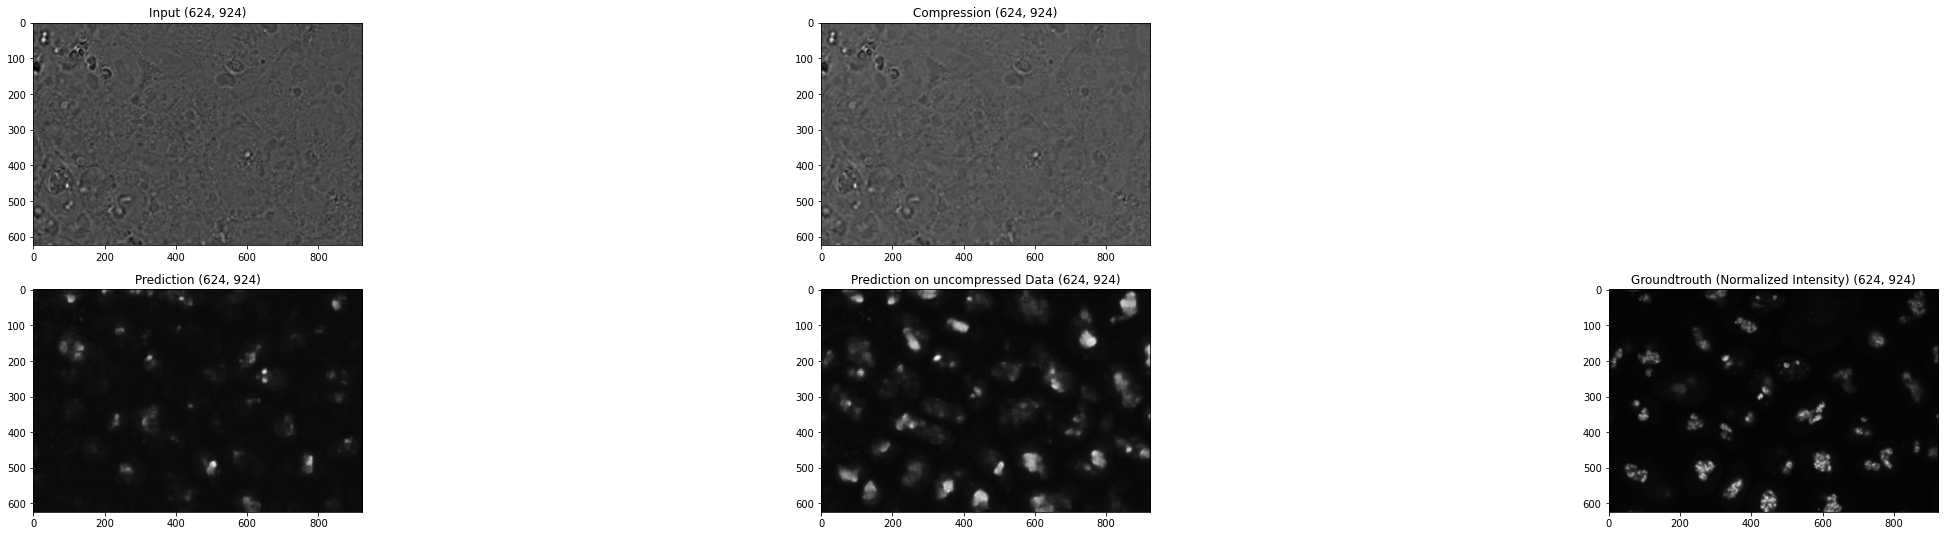

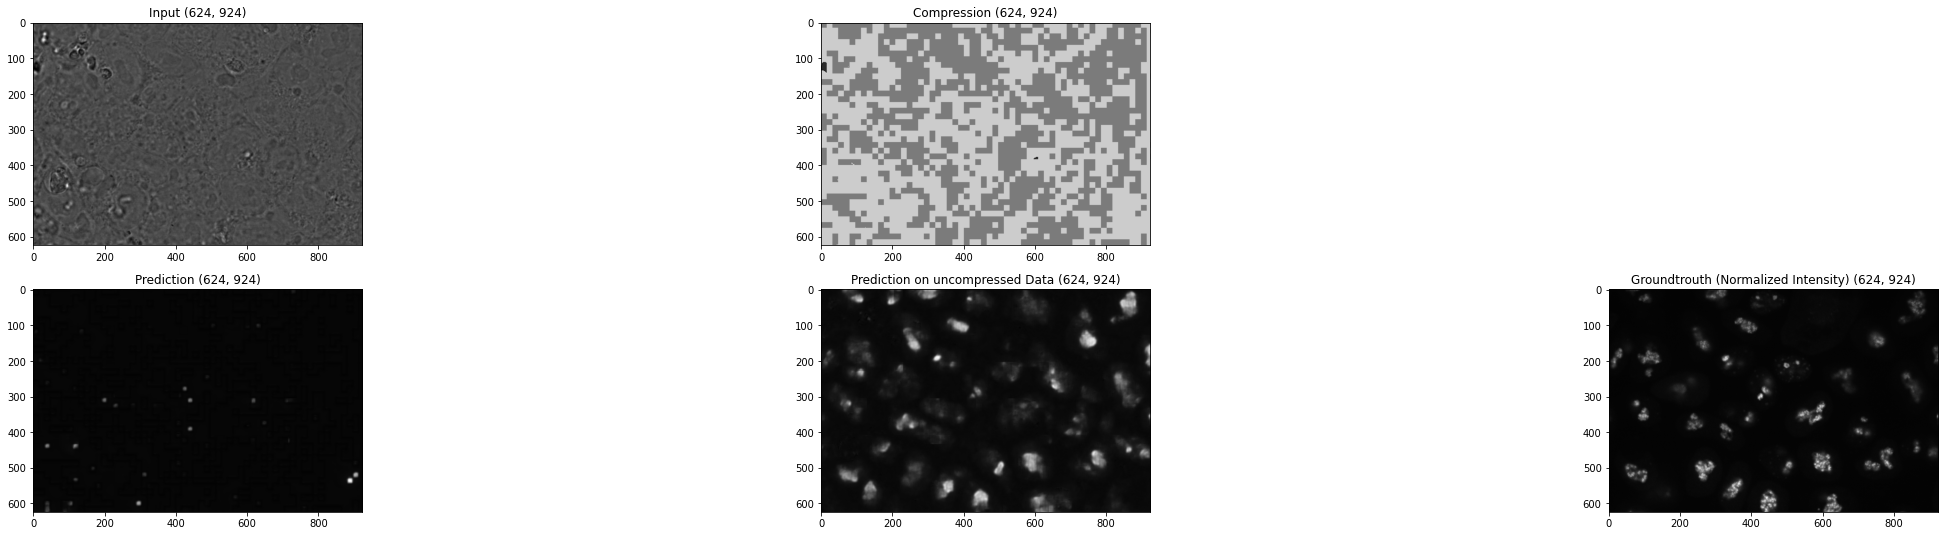

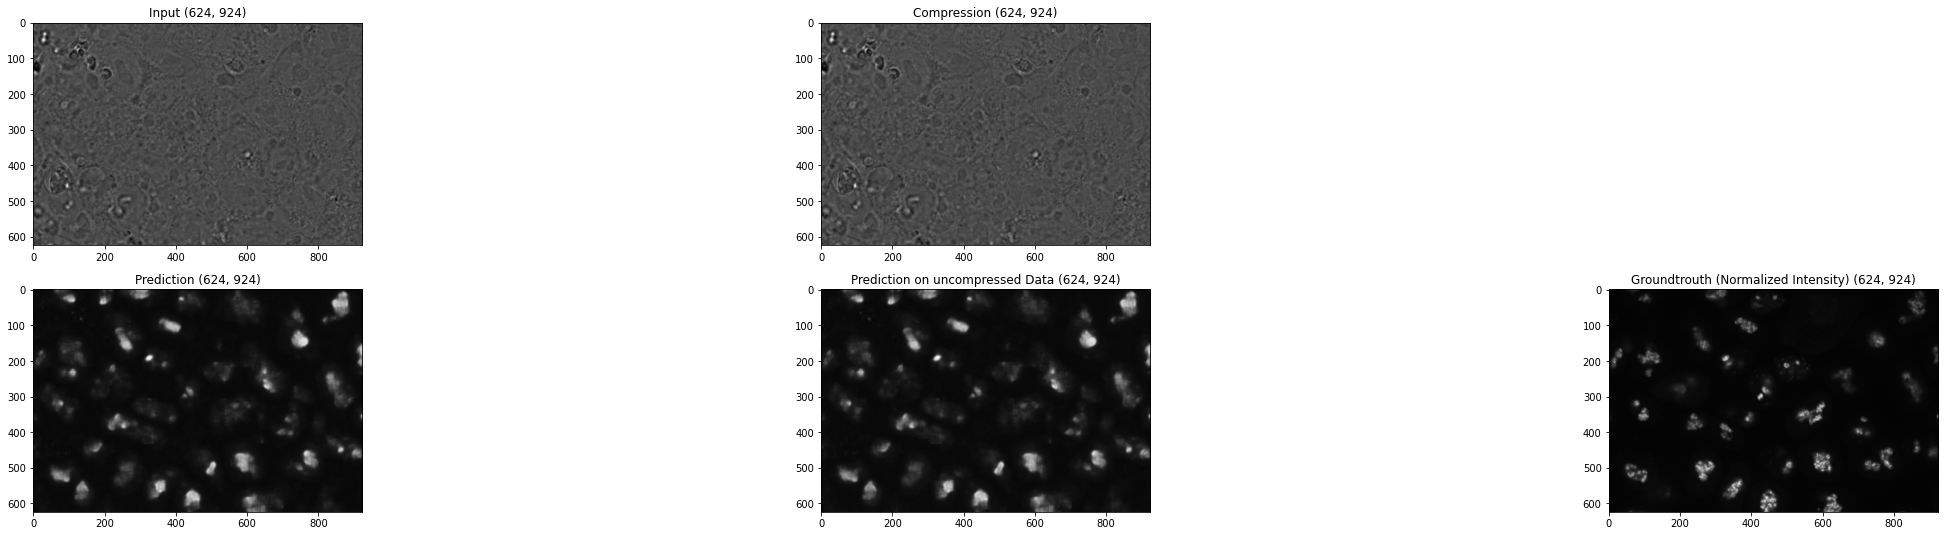

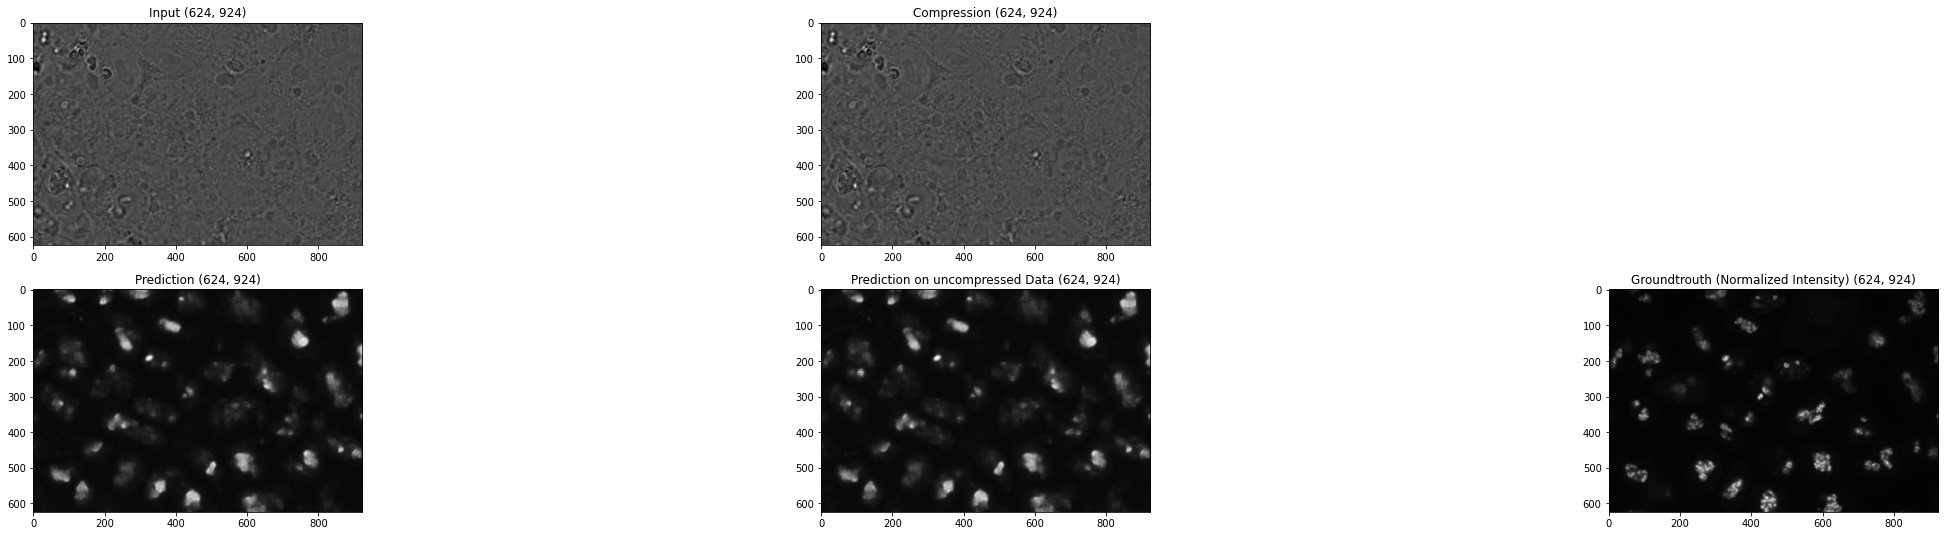

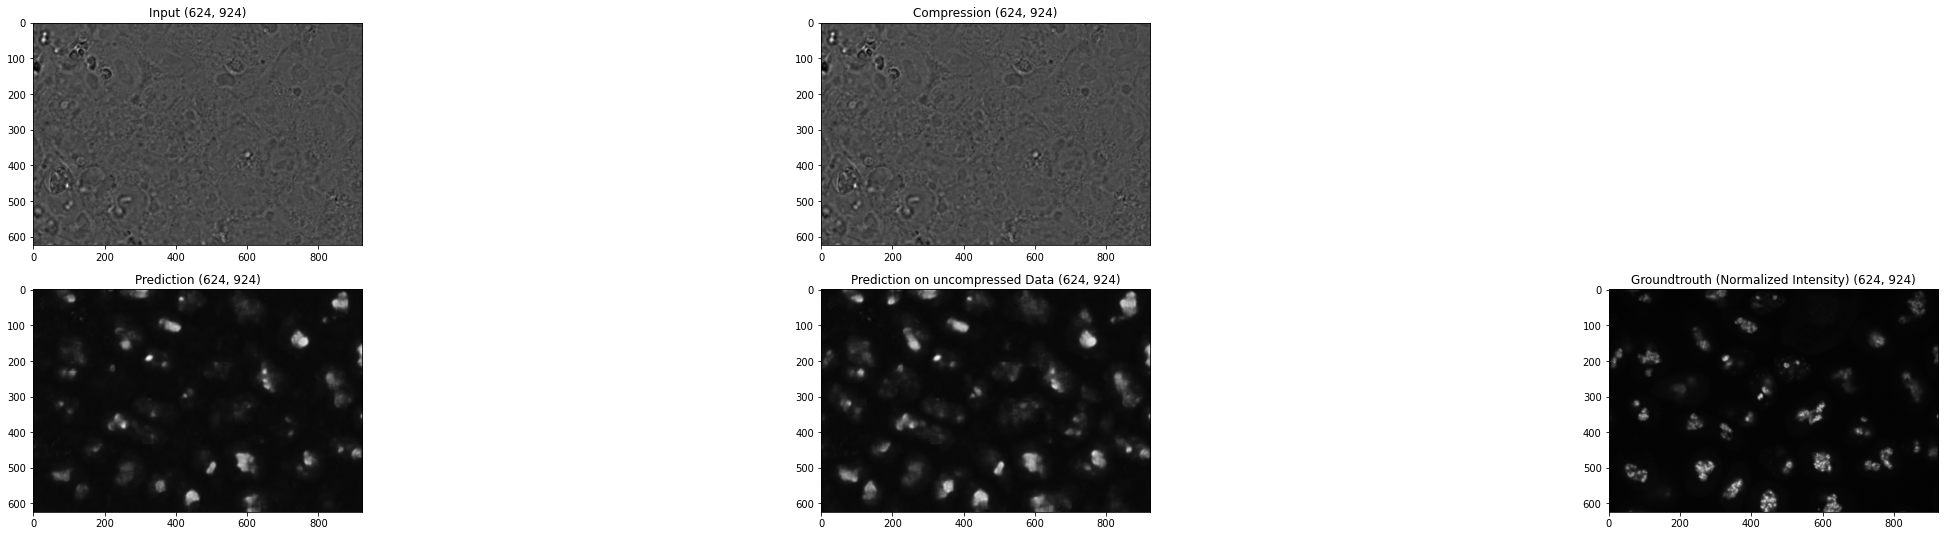

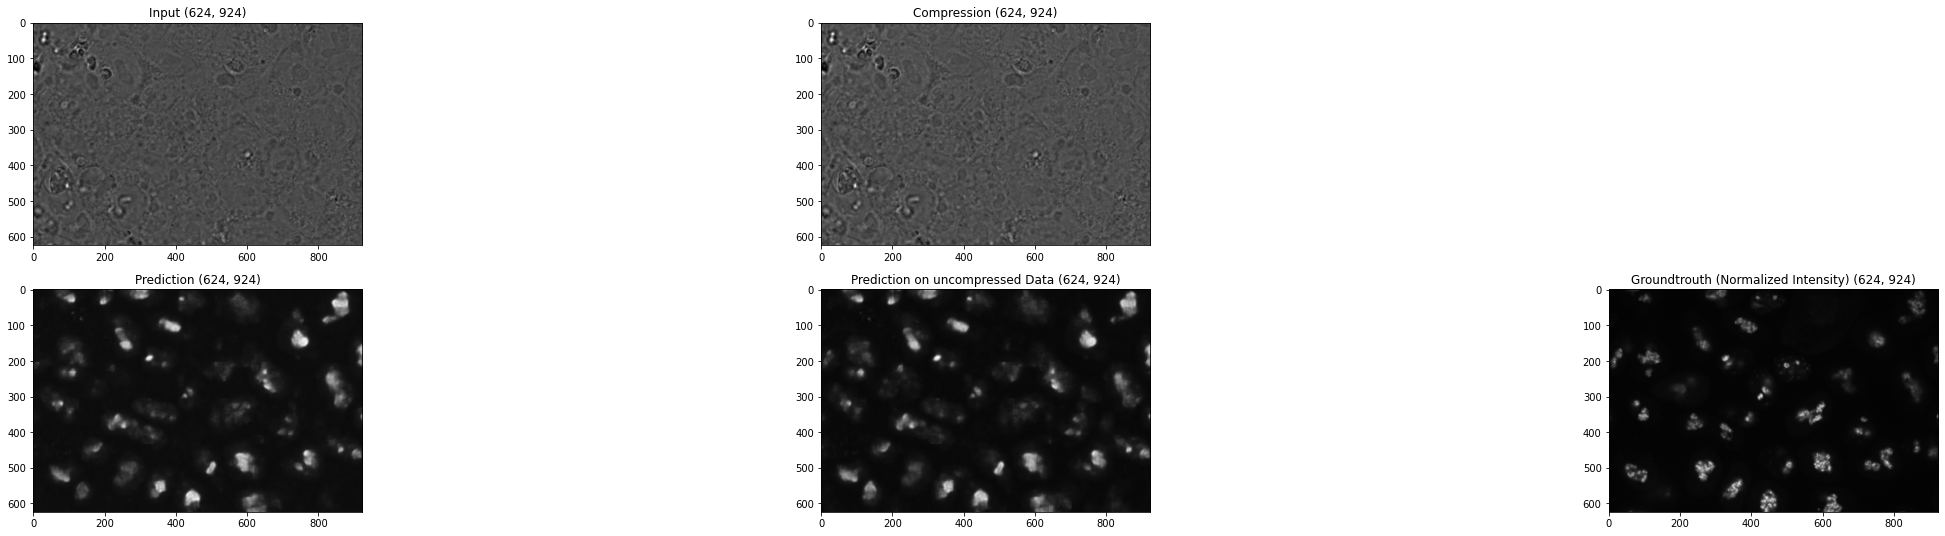

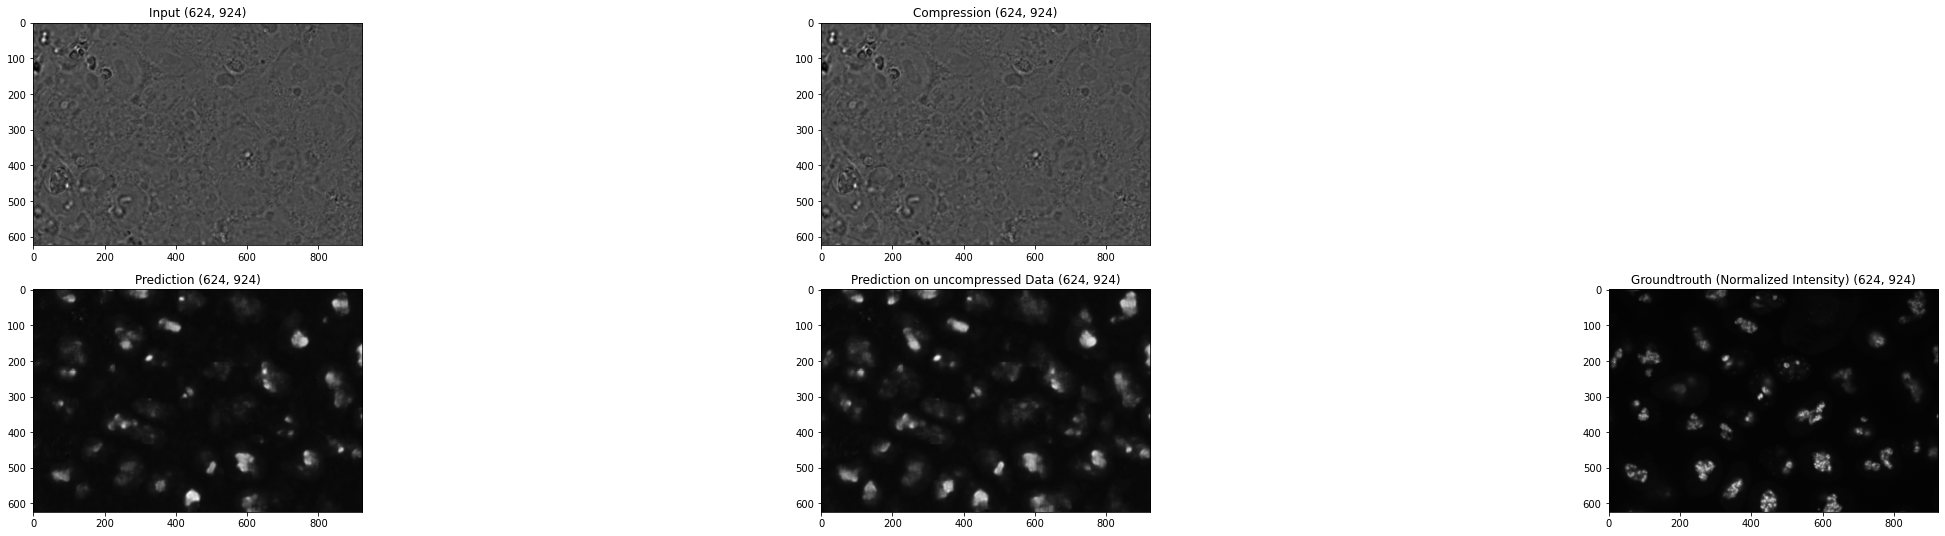

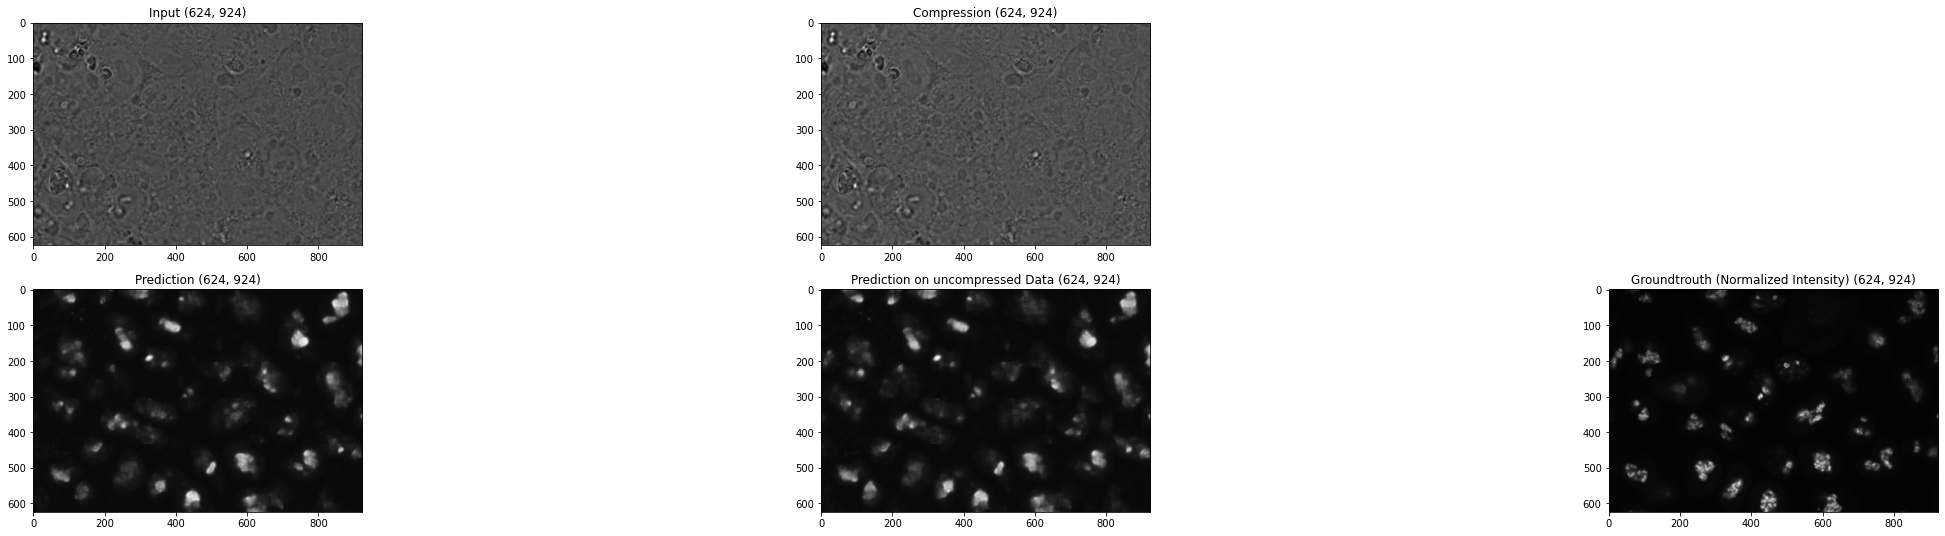

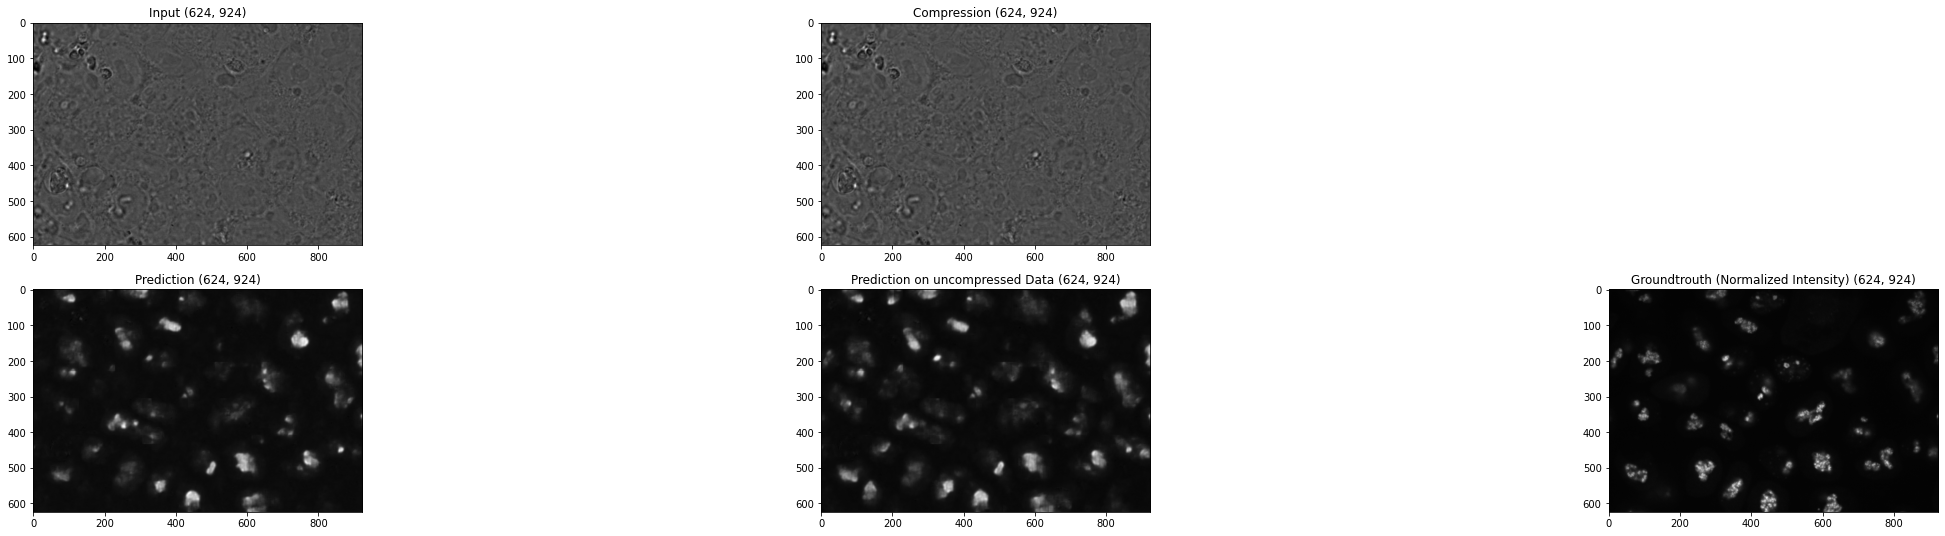

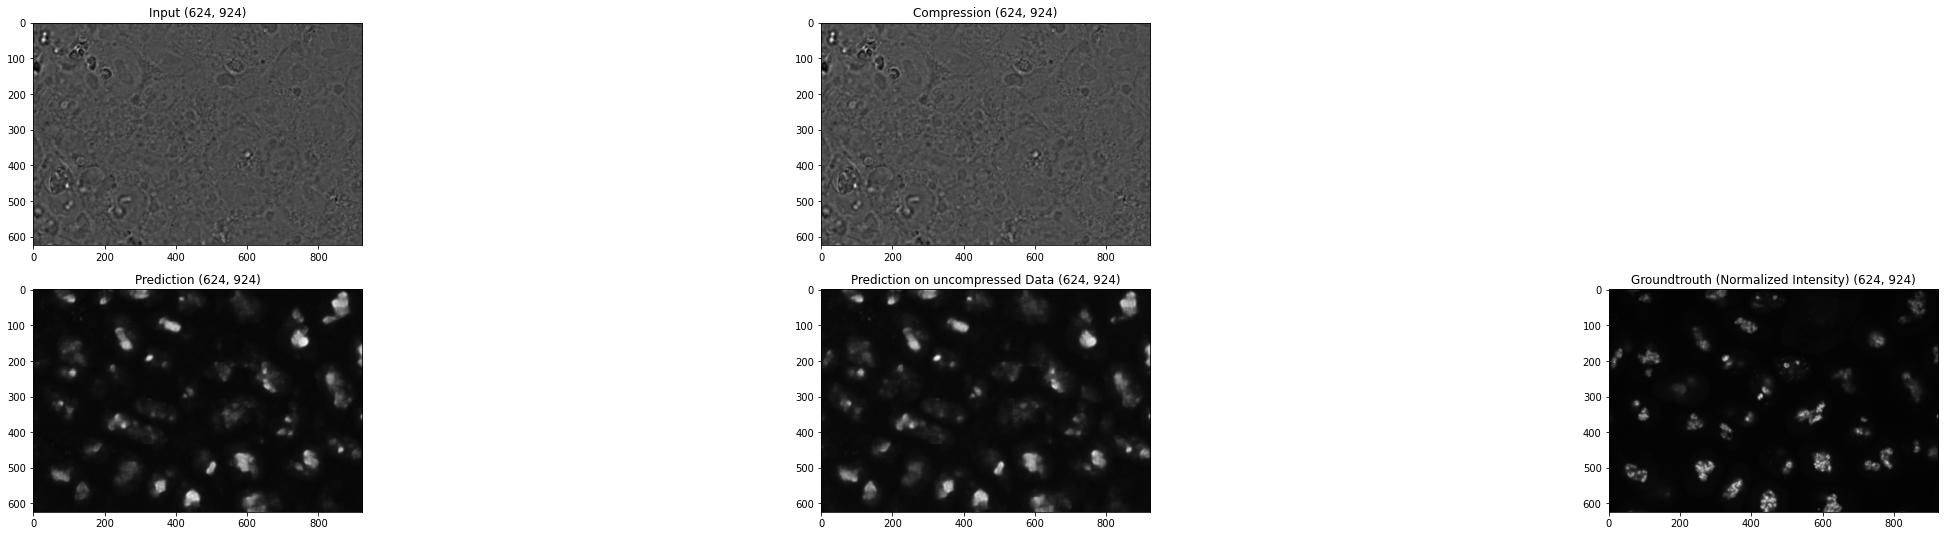

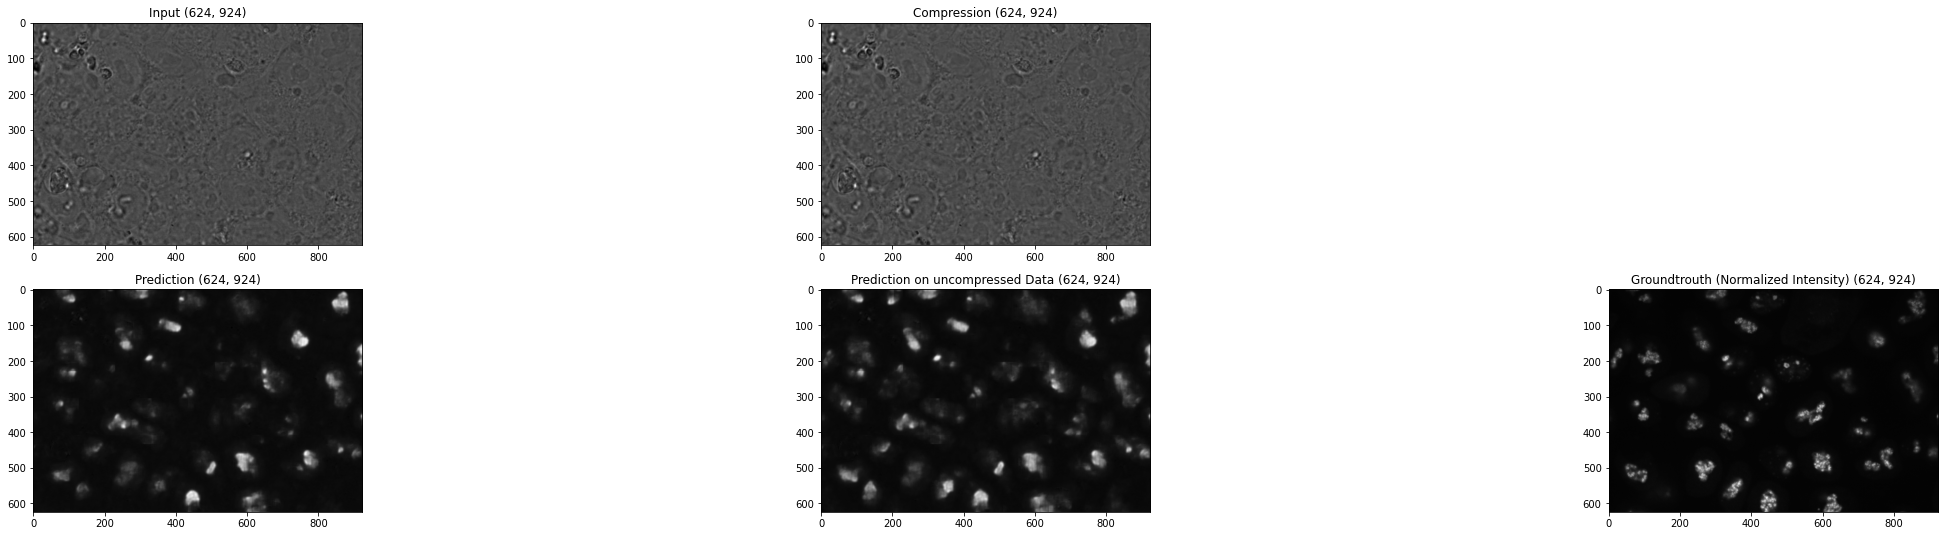

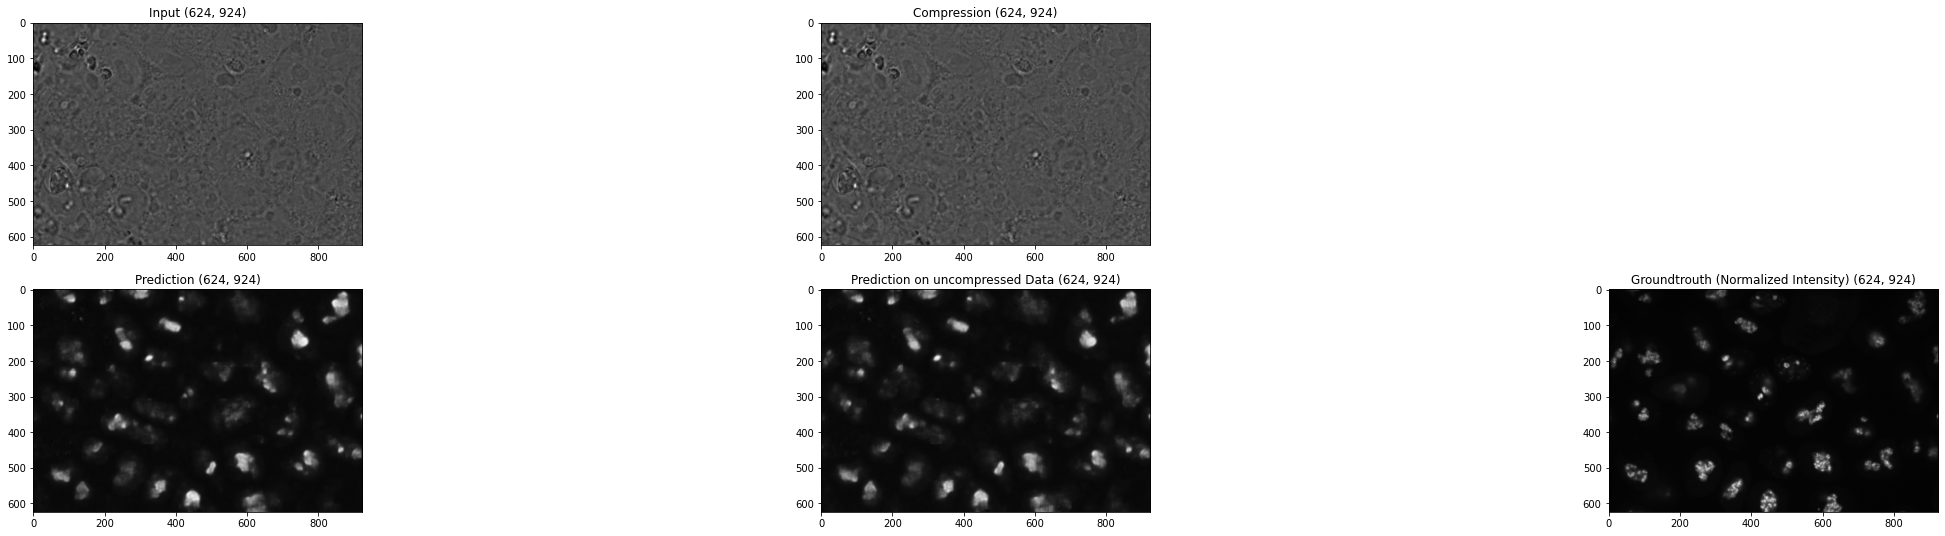

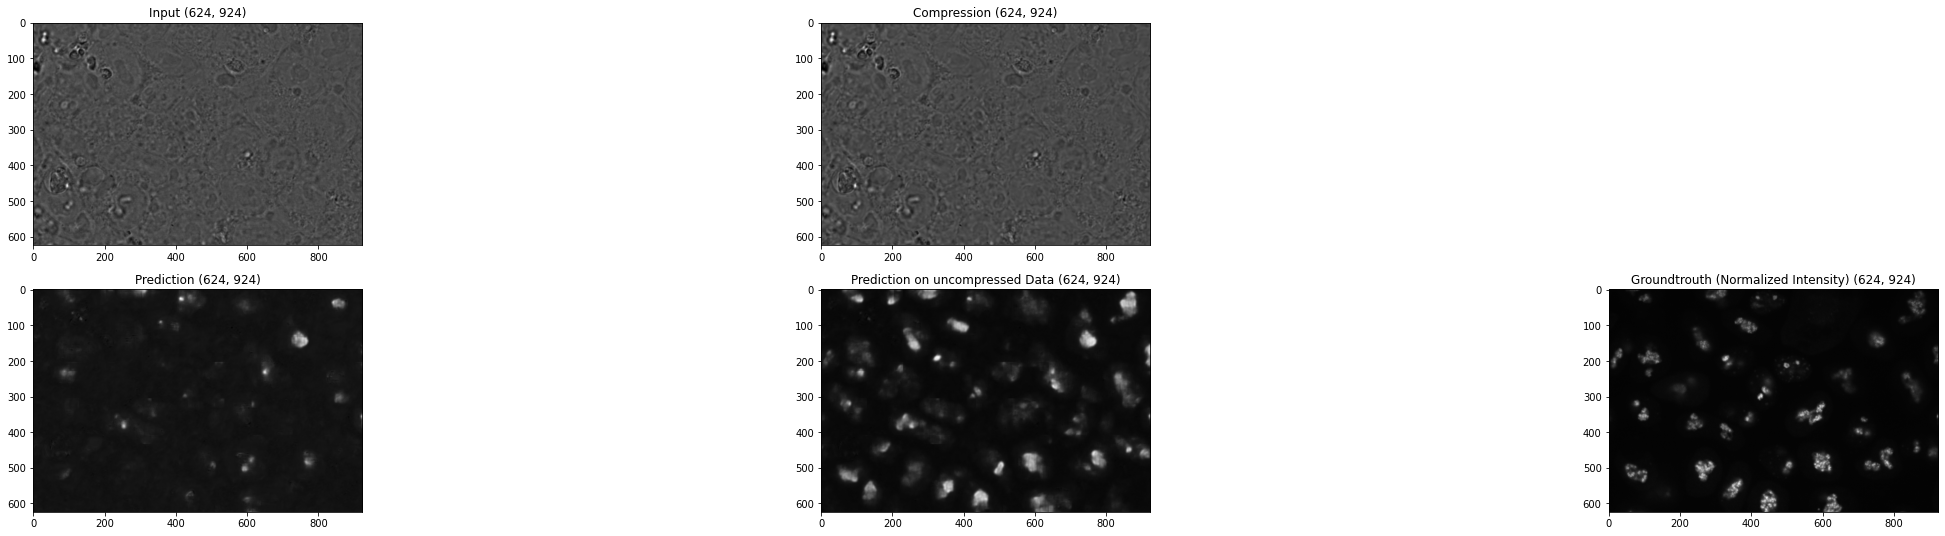

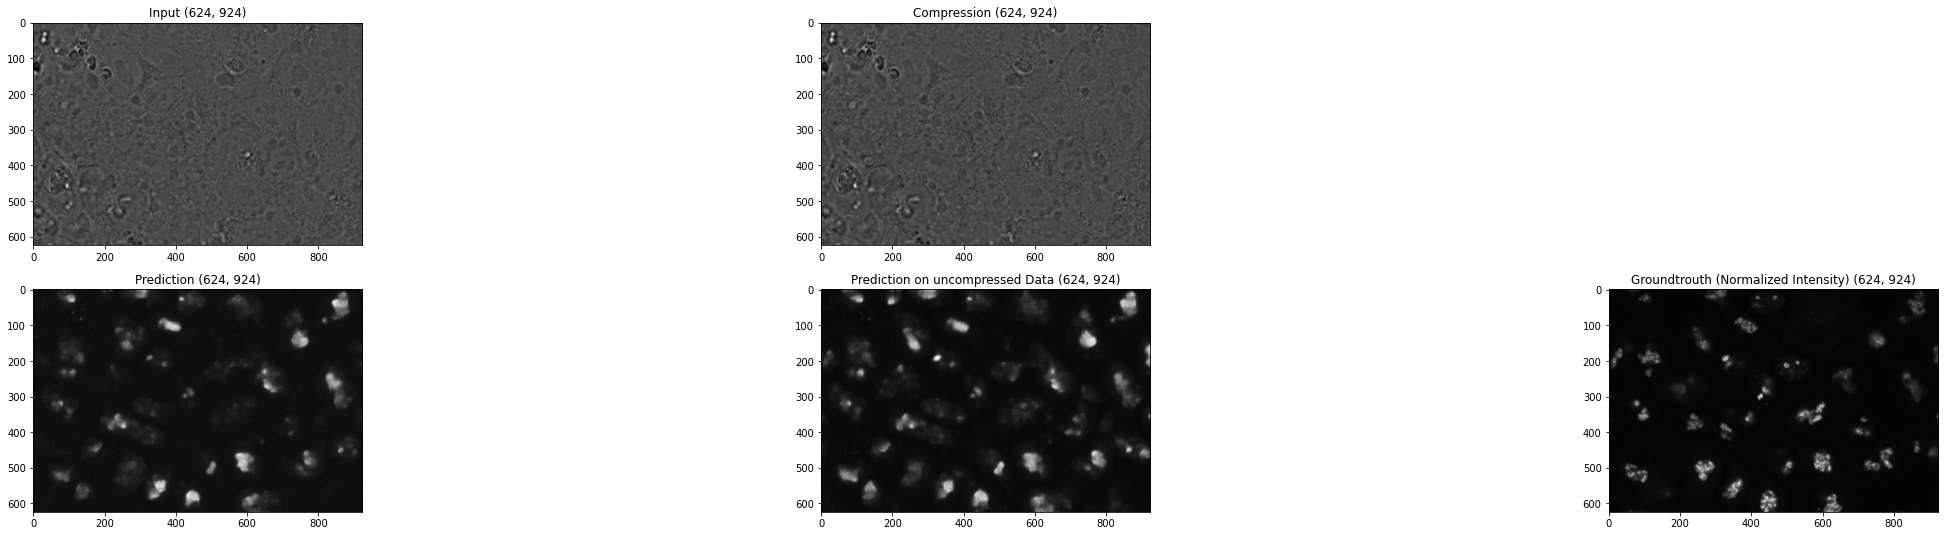

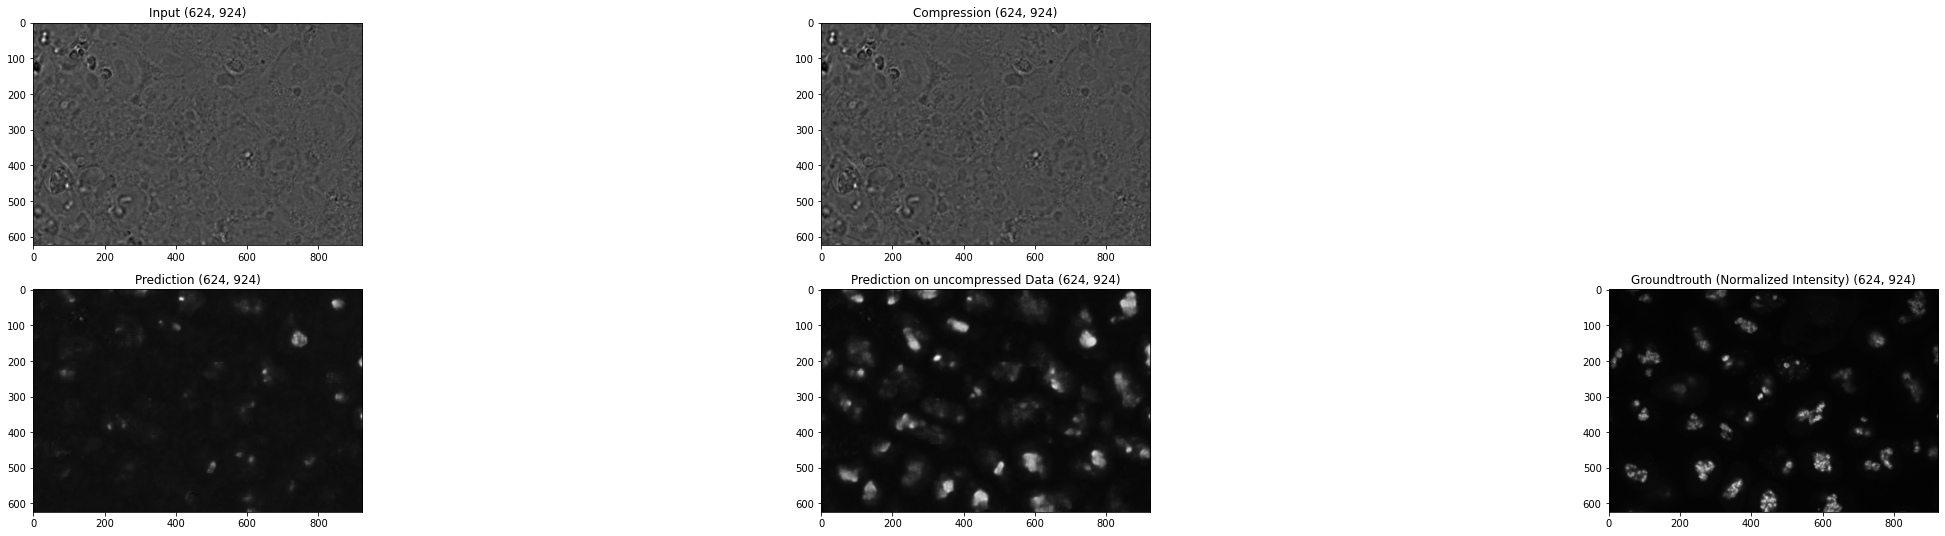

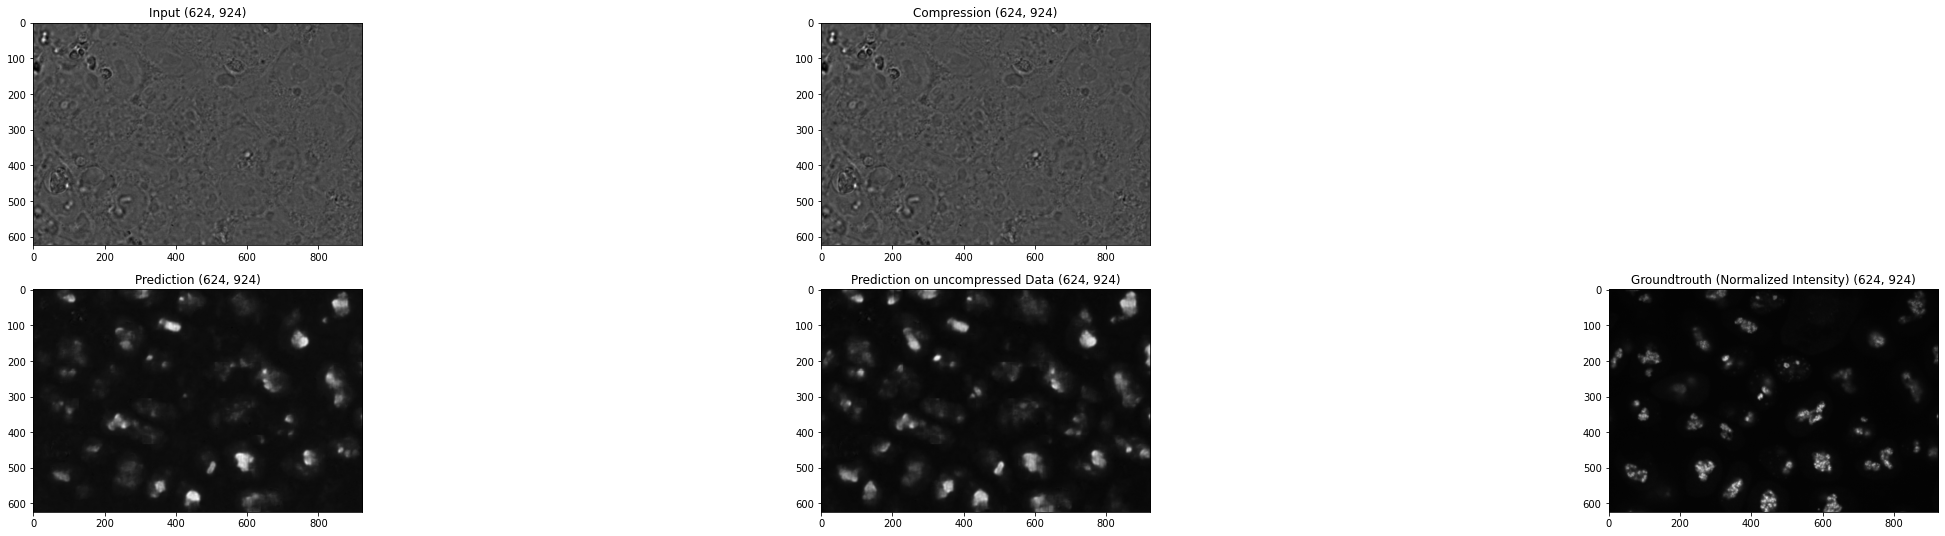

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt 
from mmv_im2im.preprocessing import transforms
from monai.transforms import NormalizeIntensity, CenterSpatialCrop, Compose
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import scipy as sc
import random
from matplotlib.patches import Rectangle
import copy
import monai
import torch

# input= dir structure: types and raw data
def plot_data(root_dir):
    #Collect all used methods
    print(root_dir)
    random_image= random.choice(list(root_dir.glob('*_IM.tiff')))
    #random_image_backup= copy.deepcopy(random_image)
    print(random_image)
    for dir in [i for i in holdout_path.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:  
        plt.figure(figsize=(40,9)) # specifying the overall grid size
        #plt.suptitle(dir.name) # or plt.suptitle('Main title')  
        input_img = AICSImage(random_image).get_image_data("YX")
        

        if dir.name in compression_techniques:
            compression_img = AICSImage(dir / random_image.name).get_image_data("YX")
        else:
            compression_img = AICSImage(dir / str(random_image.stem+'_decoded.tiff')).get_image_data("YX")

        if dir.name in compression_techniques:
            prediction_img = AICSImage(dir / 'prediction' / Path(random_image.stem+'_pred.tiff')).get_image_data("YX")
        else:
            prediction_img = AICSImage(dir / 'prediction' / Path(random_image.stem+'_decoded_pred.tiff')).get_image_data("YX")
        groundtrouth_img = AICSImage(root_dir / random_image.name.replace('IM','GT')).get_image_data("YX")
        original_prediction = AICSImage(dir.parent/ 'original' / 'prediction' / Path(random_image.stem+'_pred.tiff')).get_image_data("YX")

        # Plot
        plt.subplot(2,3,1) 
        plt.imshow(input_img, cmap='gray')
        plt.title(f'Input ' + str(np.shape(input_img)))   
        plt.subplot(2,3,2) 
        plt.imshow(compression_img, cmap='gray')
        plt.title('Compression ' + str(np.shape(compression_img)))
        plt.subplot(2,3,4)
        plt.imshow(prediction_img, cmap='gray')
        plt.title('Prediction '  + str(np.shape(prediction_img)))   
        plt.subplot(2,3,5)
        plt.imshow(original_prediction, cmap='gray')
        plt.title('Prediction on uncompressed Data ' + str(np.shape(original_prediction)))    
        plt.subplot(2,3,6)
        plt.imshow(normalizeItensity(groundtrouth_img), cmap='gray')
        plt.title('Groundtrouth (Normalized Intensity) ' + str(np.shape(groundtrouth_img)))     
        plt.savefig(dir.name+'_plot.png')
    #plt.show() 
    


plot_data(holdout_path)